# 5.2 Explanation Selectivity

## Introduction

Another desirable property of an explanation is that it redistributes relevances to variables that have the strongest impact on the function $f(x)$. One of the proposed methods is pixel-flipping where we measure how fast $f(x)$ goes down when removing features with highest relevance scores. The algorithm is given as follows:

![title](./assets/5_2_ES/fig1.png)

A sharp drop of function's value, characterized by a low AUC score indicates that the correct features have been identified as relevant. AUC results can be averaged over a large number of examples in the dataset.

In the Tensorflow walkthrough, we are going to iteratively remove a patch of size $4 \times 4$ that has the highest relevance score. We will keep track of $f(x)$ as the features are progressively removed.

## Tensorflow Walkthrough

### 1. Import Dependencies

In [1]:
import os

from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

from models.models_5_2 import MNIST_CNN, MNIST_DNN, Taylor
from utils import find_roi

%matplotlib inline

mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
images = mnist.train.images
labels = mnist.train.labels

logdir = './tf_logs/5_2_ES/'
ckptdir = logdir + 'model'

if not os.path.exists(logdir):
    os.mkdir(logdir)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


### 2. Building Graph

In [2]:
with tf.name_scope('Classifier'):

    # Initialize neural network
    DNN = MNIST_CNN('CNN')

    # Setup training process
    X = tf.placeholder(tf.float32, [None, 784], name='X')
    Y = tf.placeholder(tf.float32, [None, 10], name='Y')

    activations, logits = DNN(X)
    
    tf.add_to_collection('ES', X)
    
    for activation in activations:
        tf.add_to_collection('ES', activation)

    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=Y))

    optimizer = tf.train.AdamOptimizer().minimize(cost, var_list=DNN.vars)

    correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(Y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

cost_summary = tf.summary.scalar('Cost', cost)
accuray_summary = tf.summary.scalar('Accuracy', accuracy)
summary = tf.summary.merge_all()

### 3. Training Network

This is the step where the DNN is trained to classify the 10 digits of the MNIST images. Summaries are written into the logdir and you can visualize the statistics using tensorboard by typing this command: `tensorboard --lodir=./tf_logs`

In [3]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

saver = tf.train.Saver()
file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

# Hyper parameters
training_epochs = 15
batch_size = 100

for epoch in range(training_epochs):
    total_batch = int(mnist.train.num_examples / batch_size)
    avg_cost = 0
    avg_acc = 0
    
    for i in range(total_batch):
        batch_xs, batch_ys = mnist.train.next_batch(batch_size)
        _, c, a, summary_str = sess.run([optimizer, cost, accuracy, summary], feed_dict={X: batch_xs, Y: batch_ys})
        avg_cost += c / total_batch
        avg_acc += a / total_batch
        
        file_writer.add_summary(summary_str, epoch * total_batch + i)

    print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.9f}'.format(avg_cost), 'accuracy =', '{:.9f}'.format(avg_acc))
    
    saver.save(sess, ckptdir)

print('Accuracy:', sess.run(accuracy, feed_dict={X: mnist.test.images, Y: mnist.test.labels}))

sess.close()

Epoch: 0001 cost = 0.229090795 accuracy = 0.927618185
Epoch: 0002 cost = 0.065635326 accuracy = 0.979818192
Epoch: 0003 cost = 0.044778095 accuracy = 0.985727283
Epoch: 0004 cost = 0.034307861 accuracy = 0.989163645
Epoch: 0005 cost = 0.027771568 accuracy = 0.991272735
Epoch: 0006 cost = 0.023438408 accuracy = 0.992309098
Epoch: 0007 cost = 0.019354284 accuracy = 0.993909096
Epoch: 0008 cost = 0.016295010 accuracy = 0.994727278
Epoch: 0009 cost = 0.013088895 accuracy = 0.995836368
Epoch: 0010 cost = 0.012431883 accuracy = 0.996254549
Epoch: 0011 cost = 0.010716667 accuracy = 0.996309094
Epoch: 0012 cost = 0.009751384 accuracy = 0.996800003
Epoch: 0013 cost = 0.009352618 accuracy = 0.996854548
Epoch: 0014 cost = 0.006814919 accuracy = 0.997509093
Epoch: 0015 cost = 0.007247204 accuracy = 0.997727275
Accuracy: 0.9926


### 4. Restoring Subgraph

Here we first rebuild the DNN graph from metagraph, restore DNN parameters from the checkpoint and then gather the necessary nodes using the `tf.get_collection()` function.

In [4]:
tf.reset_default_graph()

sess = tf.InteractiveSession()

new_saver = tf.train.import_meta_graph(ckptdir + '.meta')
new_saver.restore(sess, tf.train.latest_checkpoint(logdir))

INFO:tensorflow:Restoring parameters from ./tf_logs/4_2_ES/model


### 5. Attaching Subgraph for Calculating Relevance Scores

In [5]:
conv_ksize = [1, 3, 3, 1]
pool_ksize = [1, 2, 2, 1]
conv_strides = [1, 1, 1, 1]
pool_strides = [1, 2, 2, 1]

activations = tf.get_collection('ES')
weights = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='CNN')

X = activations[0]
predictions = activations[-1]

weights.reverse()
activations.reverse()

taylor = Taylor(activations, weights, conv_ksize, pool_ksize, conv_strides, pool_strides, 'Taylor')

Rs = [taylor(i) for i in range(10)]
SA_scores = [tf.square(tf.gradients(predictions[:,i], X)) for i in range(10)]
STD_scores = [tf.gradients(predictions[:,i], X) * X for i in range(10)]

### 6. Calculating Relevance Scores $R(x_i)$ and Displaying Images

The plot indicates that the Simple Taylor Decomposition is the most selective technique of the three, contrary to the original paper. However, I only averaged over ten images, and using a larger sample size may indicate otherwise.

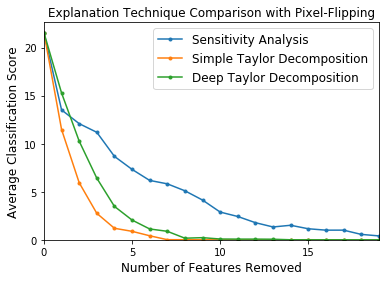

In [6]:
sample_imgs = [images[np.argmax(labels, axis=1) == i][1] for i in range(10)]
inds = list(range(10))
ksize = [4, 4]
itr = 20

sa_hmaps = []
sa_logs = []
sa_imgs = []

std_hmaps = []
std_logs = []
std_imgs = []

dtd_hmaps = []
dtd_logs = []
dtd_imgs = []

for ind in inds:
    sa_img = [sample_imgs[ind]]
    sa_coords = []
    sa_hmap = []
    sa_log = []
    
    std_img = [sample_imgs[ind]]
    std_coords = []
    std_hmap = []
    std_log = []
    
    dtd_img = [sample_imgs[ind]]
    dtd_coords = []
    dtd_hmap = []
    dtd_log = []

    for i in range(itr):
        sa_lg, sa_res = sess.run([predictions[:,ind], SA_scores[ind]], feed_dict={X: sa_img[-1][None,:]})
        std_lg, std_res = sess.run([predictions[:,ind], STD_scores[ind]], feed_dict={X: std_img[-1][None,:]})
        dtd_lg, dtd_res = sess.run([predictions[:,ind], Rs[ind]], feed_dict={X: dtd_img[-1][None,:]})
        
        sa_hmap.append(sa_res[0].reshape(784))
        sa_log.append(sa_lg.reshape([]))
        
        std_hmap.append(std_res.reshape(784))
        std_log.append(std_lg.reshape([]))
        
        dtd_hmap.append(dtd_res.reshape(784))
        dtd_log.append(dtd_lg.reshape([]))

        sa_coord = find_roi(np.square(sa_res[0]).reshape(28,28), ksize, sa_coords)
        sa_coords.append(sa_coord)
        
        std_coord = find_roi(std_res.reshape(28,28), ksize, std_coords)
        std_coords.append(std_coord)
        
        dtd_coord = find_roi(dtd_res.reshape(28,28), ksize, dtd_coords)
        dtd_coords.append(dtd_coord)
        
        if i is itr - 1:
            break

        temp = np.copy(sa_img[-1])
        temp = temp.reshape(28,28) 
        temp[sa_coord[0]:sa_coord[0]+ksize[0], sa_coord[1]:sa_coord[1]+ksize[1]].fill(0)
        sa_img.append(temp.reshape(784))
        
        temp = np.copy(std_img[-1])
        temp = temp.reshape(28,28) 
        temp[std_coord[0]:std_coord[0]+ksize[0], std_coord[1]:std_coord[1]+ksize[1]].fill(0)
        std_img.append(temp.reshape(784))
        
        temp = np.copy(dtd_img[-1])
        temp = temp.reshape(28,28) 
        temp[dtd_coord[0]:dtd_coord[0]+ksize[0], dtd_coord[1]:dtd_coord[1]+ksize[1]].fill(0)
        dtd_img.append(temp.reshape(784))
    
    sa_hmaps.append(sa_hmap)
    sa_logs.append(sa_log)
    sa_imgs.append(sa_img)
    
    std_hmaps.append(std_hmap)
    std_logs.append(std_log)
    std_imgs.append(std_img)
    
    dtd_hmaps.append(dtd_hmap)
    dtd_logs.append(dtd_log)
    dtd_imgs.append(dtd_img)

fig = plt.figure()
ax = fig.add_subplot(111)

x = list(range(itr))
y1 = np.average(sa_logs, axis=0)
y2 = np.average(std_logs, axis=0)
y3 = np.average(dtd_logs, axis=0)

ax.plot(x,y1, label='Sensitivity Analysis', marker='.')
ax.plot(x,y2, label='Simple Taylor Decomposition', marker='.')
ax.plot(x,y3, label='Deep Taylor Decomposition', marker='.')
ax.set_title('Explanation Technique Comparison with Pixel-Flipping', fontdict={'fontsize': 12})
ax.set_xlabel('Number of Features Removed', fontdict={'fontsize': 12})
ax.set_ylabel('Average Classification Score', fontdict={'fontsize': 12})
ax.set_xticks(list(range(0, 20, 5)))
ax.set_xbound(0, 19)
ax.set_ybound(0)

ax.legend(fontsize='large')

This is the image of the digit as the features are removed and the heat map produced by Deep Taylor Decomposition. We cam see that the heat map grows fainter and fainter, and at the end, Deep Taylor Decomposition no longer provides an explanation.

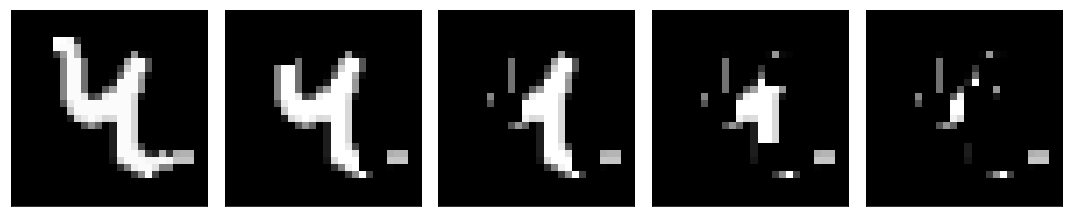

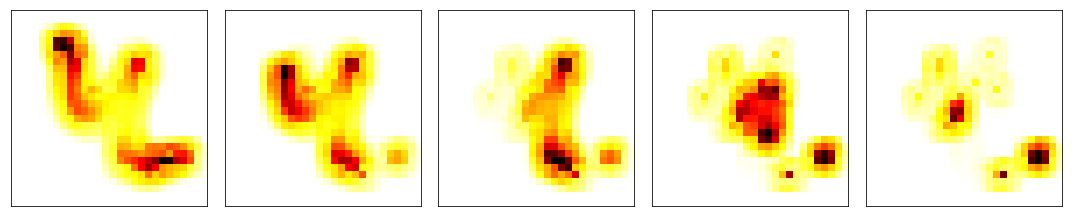

In [7]:
digit = 4

fig = plt.figure(figsize=[15,15])
for i in range(5):      
    ax = fig.add_subplot(1, 5, i + 1)
    ax.imshow(dtd_imgs[digit][i * 2].reshape([28,28]), cmap='gray')
    ax.tick_params(labelbottom='off', labelleft='off', bottom='off', left='off')
plt.tight_layout()

fig = plt.figure(figsize=[15,15])
for i in range(5):      
    ax = fig.add_subplot(1, 5, i + 1)
    ax.imshow(dtd_hmaps[digit][i * 2].reshape([28,28]), cmap='hot_r')
    ax.tick_params(labelbottom='off', labelleft='off', bottom='off', left='off')
plt.tight_layout()